<a href="https://colab.research.google.com/github/Vic-the-Legend/Transformers-and-NER/blob/main/BERT_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and Import Packages

In [1]:
!pip install datasets
!pip install transformers
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 8.2 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, pipeline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import gc
import torch
from scipy import special

## Load and Wrangle Data

In [12]:
# Specify number of labels when training
num_labels = 2

# Change the number of labels
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = num_labels).to('cuda')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Financial Phrase Bank

In [13]:
from datasets import load_dataset
phrases = load_dataset('financial_phrasebank', 'sentences_50agree')
data = phrases['train']
data.set_format("pandas")
data = data[:]
data

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,0
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4843,Operating profit fell to EUR 35.4 mn from EUR ...,0
4844,Net sales of the Paper segment decreased to EU...,0


<Axes: >

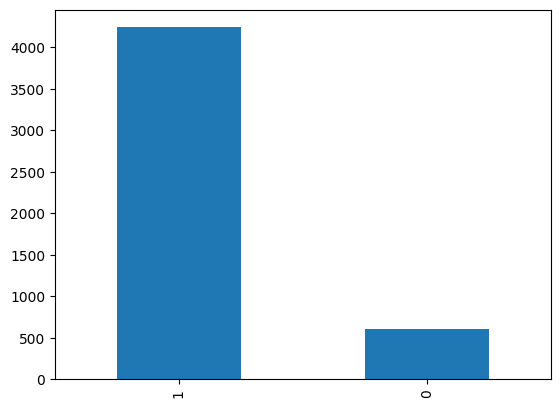

In [14]:
data["label"] = np.where(data['label'] >= 1, 1, 0)
data["label"].value_counts().plot(kind = 'bar')

In [15]:
df_train, df_test = train_test_split(data, shuffle = True, test_size=0.2, stratify=data['label'])
df_train, df_val = train_test_split(df_train, test_size=0.125, stratify=df_train['label'])
print(df_train.shape, df_test.shape, df_val.shape)

(3391, 2) (970, 2) (485, 2)


### Financial News Title

In [16]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"victhelegend", "key":"d4c0f439012ee1a25d831a58a54aa5e8"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [17]:
!kaggle datasets download -d percyzheng/sentiment-classification-selflabel-dataset
!mkdir '/content/data'

sentiment-classification-selflabel-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘/content/data’: File exists


In [18]:
!unzip -qo /content/sentiment-classification-selflabel-dataset -d '/content/data'

In [24]:
df = pd.read_csv('/content/data/self_label.csv', encoding='latin-1')#.rename(columns={'text':'sentence', 'sentiment':'label'}) ## use your own customized dataset
df

,text,sentiment
0,Global COVID-19 death toll exceeds 4 million.,0
1,"reports 67,208 new COVID-19 cases, 2,330 deaths.",0
2,China reports 23 new COVID-19 cases versus 19 ...,0
3,"India records 91,702 new COVID-19 cases over p...",0
4,sharply raises COVID-19 death toll prompting c...,0
...,...,...
206,U.S. equity futures were trading higher the mo...,2
207,"China, US commerce chiefs to cooperate on hand...",2
208,Stock investors celebrate red-hot five-quarter...,2
209,Wall Streetâs roaring 2021 is as good as it ...,2


In [25]:
df = df.rename(columns={'text':'sentence', 'sentiment':'label'})

In [26]:
df = df.dropna(subset=['sentence', 'label']) ## drop missing values
df['label'] = df['label'].map({0:2, 1:0, 2:1})

<Axes: >

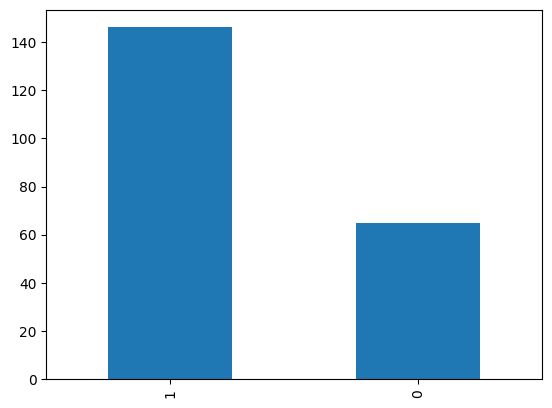

In [27]:
df["label"] = np.where(df['label'] >= 1, 1, 0)
df["label"].value_counts().plot(kind = 'bar')

In [28]:
df

,sentence,label
0,Global COVID-19 death toll exceeds 4 million.,1
1,"reports 67,208 new COVID-19 cases, 2,330 deaths.",1
2,China reports 23 new COVID-19 cases versus 19 ...,1
3,"India records 91,702 new COVID-19 cases over p...",1
4,sharply raises COVID-19 death toll prompting c...,1
...,...,...
206,U.S. equity futures were trading higher the mo...,1
207,"China, US commerce chiefs to cooperate on hand...",1
208,Stock investors celebrate red-hot five-quarter...,1
209,Wall Streetâs roaring 2021 is as good as it ...,1


In [29]:
title_train, title_test, = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)
title_train, title_val = train_test_split(title_train, stratify=title_train['label'],test_size=0.125, random_state=42)
print(title_train.shape, title_test.shape, title_val.shape)

(147, 2) (43, 2) (21, 2)


###

In [3]:
twitter = pd.read_csv('twitter_train.csv') ## use your own customized dataset
twitter_train, twitter_val = train_test_split(twitter, stratify=twitter['label'], test_size=0.125, random_state=42)
twitter_test = pd.read_csv('twitter_valid.csv')

FileNotFoundError: ignored

## Transformer Fine Tuning

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [8]:
dataset_train_DistilBERT = Dataset.from_pandas(df_train)
dataset_val_DistilBERT = Dataset.from_pandas(df_val)
dataset_test_DistilBERT = Dataset.from_pandas(df_test)

dataset_train_DistilBERT = dataset_train_DistilBERT.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val_DistilBERT = dataset_val_DistilBERT.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test_DistilBERT = dataset_test_DistilBERT.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train_DistilBERT.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_val_DistilBERT.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_test_DistilBERT.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/3391 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [9]:
torch.cuda.empty_cache()
gc.collect()

186

In [10]:
num_labels = len(data["label"].unique())
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = num_labels).to('cuda')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

batch_size = 32
logging_steps = df_train.shape[0] // batch_size


args_DistilBERT = TrainingArguments(
        output_dir = 'temp/',
        num_train_epochs=5,
        learning_rate=2e-5,
        warmup_steps = 0,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        #weight_decay=0.01,
        evaluation_strategy = 'epoch',
        logging_steps=logging_steps
        #save_strategy = 'epoch',
        #load_best_model_at_end=True,
        #metric_for_best_model='accuracy',
)

trainer_DistilBERT = Trainer(
        model=model,
        args=args_DistilBERT,
        train_dataset=dataset_train_DistilBERT,         # training dataset
        eval_dataset=dataset_val_DistilBERT,            # evaluation dataset
        compute_metrics=compute_metrics
)

trainer_DistilBERT.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.267300,0.115911,0.958763,0.959598
2,0.116800,0.100552,0.969072,0.968730
3,0.064900,0.107387,0.964948,0.965769
4,0.034200,0.097344,0.971134,0.970923
5,0.024100,0.097511,0.975258,0.974889


TrainOutput(global_step=530, training_loss=0.10064446820684199, metrics={'train_runtime': 182.2873, 'train_samples_per_second': 93.013, 'train_steps_per_second': 2.907, 'total_flos': 561496186053120.0, 'train_loss': 0.10064446820684199, 'epoch': 5.0})

In [12]:
trainer_DistilBERT.evaluate()

{'eval_loss': 0.09751144796609879,
 'eval_accuracy': 0.9752577319587629,
 'eval_f1': 0.974889085552108,
 'eval_runtime': 1.7591,
 'eval_samples_per_second': 275.711,
 'eval_steps_per_second': 9.096,
 'epoch': 5.0}

In [13]:
def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [14]:
prediction = trainer_DistilBERT.predict(dataset_test_DistilBERT)

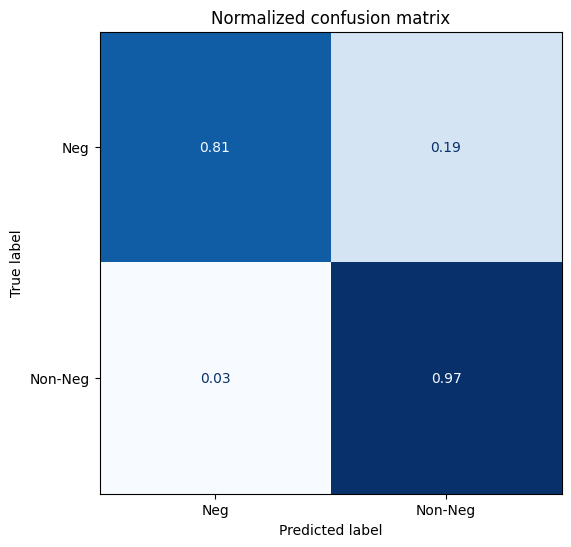

In [15]:
plot_confusion_matrix(np.argmax(prediction.predictions, axis=1), df_test['label'], ["Neg", "Non-Neg"])

### Save model

In [16]:
save_directory = "two_label/"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('two_label/tokenizer_config.json',
 'two_label/special_tokens_map.json',
 'two_label/vocab.txt',
 'two_label/added_tokens.json')

### Test saved model

In [17]:
# Directory of saved tuned model on financial phrase data
save_directory = "two_label/"
model = DistilBertForSequenceClassification.from_pretrained(save_directory)
tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
trained_model = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer) # top_k = None allows for all probabilities to show

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
predictions = trained_model.predict(df_test["sentence"].tolist())

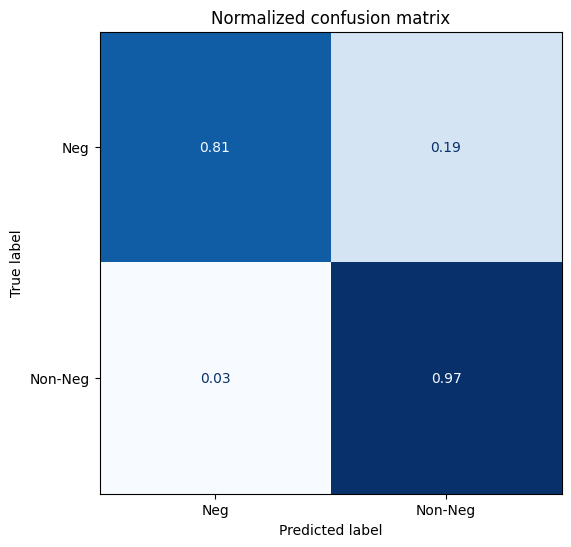

In [19]:
indices = [int(pred['label'][-1]) for pred in predictions]
plot_confusion_matrix(indices, df_test['label'], ["Neg", "Non-Neg"])